In [1]:
## bring in needed mods
import pandas as pd, numpy as np
from Bio.Seq import Seq
from Bio import SeqIO

In [2]:
chrom = 'Chr02'
peak = (848749,989618)

In [3]:
chromint = str(int(chrom[-2:]))

In [4]:
contigpath = '/Users/croth/Desktop/CRYPTO_QTL/FILES/%s/%s.fasta'%(chrom,chrom)
contigrec = [rec for rec in SeqIO.parse(contigpath,contigpath.split('.')[-1])][0]

In [5]:
vardf = pd.read_csv('../FILES/OLD/OCT2018/CDx-ill-SNP-INDEL-CHR%s-df-104.csv'%(chromint),
                    index_col=0)
vardf.head()

,Pos,Ref,Alt,Start,End,aStart,aEnd,Subtype,status,invcf,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_Correction,SS-B873_Correction,SS-B360,SS-B397,SS-B564,SS-B382
0,2458,CGATG,TGGTG,2457,2462,2458,2462,ins,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2532,ACCCGA,ACCGA,2531,2537,2532,2537,del,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2550,GATTTATTTAC,GATTTAC,2549,2560,2550,2560,del,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2637,ATTAG,CCTTTACATCAAG,2636,2641,2637,2641,ins,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3016,GG,CG,3015,3017,3016,3017,ins,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [6]:
#ch_gff_path  ='../FILES/%s/%s_xl280_gff.csv'%(chrom,chrom)
gff_path = '../FILES/xl280genome.gff.csv'
gff = pd.read_csv(gff_path,index_col=0,header=0)
gff.drop(['chrom','start','end'],inplace=True,axis=1)
gff.columns = ['type','strand','phase','attribute','gene','start','end','chrom']

In [7]:
ch_gff = gff[(gff.chrom==chrom)].sort_values(by='start')
ch_gff.head()

,type,strand,phase,attribute,gene,start,end,chrom
48958,CDS,+,0,ID=CNB00010-t26_1-p1-CDS1;Parent=CNB00010-t26_...,CNB00010,637,1652,Chr02
48956,exon,+,.,ID=exon_CNB00010-E1;Parent=CNB00010-t26_1,CNB00010,637,1652,Chr02
48955,mRNA,+,.,ID=CNB00010-t26_1;Parent=CNB00010;description=...,CNB00010,637,2012,Chr02
48954,gene,+,.,ID=CNB00010;description=hypothetical protein,CNB00010,637,2012,Chr02
48959,CDS,+,2,ID=CNB00010-t26_1-p1-CDS2;Parent=CNB00010-t26_...,CNB00010,1710,2012,Chr02


In [8]:
def gff_gene(gene,vardf,gff,sequen,savepath=None,verbose=False):
    ggff = gff[(gff.gene==gene)]
    gvdf = vardf[(vardf.Pos >= ggff.start.min()) & 
             (vardf.Pos <= ggff.end.max())][[
            'Start','End','Ref','Alt']].copy()
    if gvdf.shape[0] == 0:
        if verbose:
            print(gvdf.shape)
            print('No genetic variants in %s'%(gene))
        return []
    gvdf['Var'] = 1
    variant_positions = np.concatenate([np.arange(*a[1][['Start','End']]) 
                                    for a in gvdf.iterrows()])
    non_variant_positions = [a for a in np.arange(ggff.start.min(),ggff.end.max()) 
                         if a not in variant_positions]
    non_variants = [str(sequen[p:p+1]) for p in non_variant_positions]
    gnvdf = pd.DataFrame([non_variant_positions,non_variant_positions,
                      non_variants,non_variants,
                      list(np.zeros(len(non_variant_positions)))],
                     index=['Start','End','Ref','Alt','Var']).T
    gdf = pd.concat([gvdf,gnvdf]).sort_values(by=['Start','End']).reset_index(drop=True)
    gdf['Strand'] = [1 if ggff.strand.unique()[0] == '+' else -1][0]
    gdf['Seq'] = 0
    gdf['Gene'] = gene
    for g in ggff[(ggff.type=='CDS')].iterrows():
        fpos = np.arange(g[1].start,g[1].end)
        gdf.at[gdf.Start.isin(fpos),'Seq'] = 1
    for g in ggff[(ggff.type=='three_prime_UTR')].iterrows():
        fpos = np.arange(g[1].start,g[1].end)
        gdf.at[gdf.Start.isin(fpos),'Seq'] = 3
    for g in ggff[(ggff.type=='five_prime_UTR')].iterrows():
        fpos = np.arange(g[1].start,g[1].end)
        gdf.at[gdf.Start.isin(fpos),'Seq'] = 5
    if savepath is not None:
        gdf.to_csv(savepath)
    return gdf

def gene_protien(gdf,a='Ref',tostop=True):
    strand = gdf.Strand.unique()[0]
    if strand > 0:
        aa = Seq(''.join(gdf[(gdf.Seq==1)][a].tolist())).translate(to_stop=tostop)
    else:
        assert strand < 0
        aa = Seq(''.join(gdf[(gdf.Seq==1)][a].tolist())).reverse_complement().translate(to_stop=tostop)
    return aa

def protien_compare(a,b):
    if len(a) != len(b):
        flag = 'Modified:%s'%(str(len(a)-len(b)))
    else:
        flag = []
        for i, k in enumerate(a):
            if k != b[i]:
                flag.append(i)
        if len(flag) == 0:
            assert len(a) == len(b)
            flag = 'Synonymous'
        else:
            flag = ','.join([str(a) for a in flag])
    return flag   

In [9]:
peak_genes = ch_gff[(ch_gff.start>=peak[0]) & 
                    (ch_gff.end<=peak[-1])].gene.unique()

In [10]:
len(peak_genes)

48

In [11]:
peak_gene_res = []
for gene in peak_genes:
    genegdf = gff_gene(gene,vardf,ch_gff,contigrec.seq)
    if len(genegdf) == 0:
        peak_gene_res.append('Nonvariant')
        continue
    gene_r_aa = gene_protien(genegdf,a='Ref')
    gene_a_aa = gene_protien(genegdf,a='Alt')
    peak_gene_res.append(protien_compare(gene_r_aa,gene_a_aa))

/Users/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2576: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [12]:
peak_gene_res_df = pd.DataFrame([peak_genes,peak_gene_res],
                                index=['Name','Result']).T

In [13]:
peak_gene_res_df.sort_values('Name',inplace=True)

In [14]:
peak_gene_res_df

,Name,Result
0,CNB02860,"2,318,376"
1,CNB02870,Synonymous
2,CNB02880,Nonvariant
3,CNB02890,Nonvariant
4,CNB02900,Nonvariant
5,CNB02910,Nonvariant
6,CNB02920,Nonvariant
7,CNB02930,Nonvariant
8,CNB02940,Nonvariant
9,CNB02950,Nonvariant


In [15]:
peak_gene_nonsyn =  peak_gene_res_df[(peak_gene_res_df.Result!='Synonymous') & 
                 (peak_gene_res_df.Result!='Nonvariant')]
print(peak_gene_nonsyn.shape[0])

16


In [16]:
peak_gene_nonsyn

,Name,Result
0,CNB02860,"2,318,376"
14,CNB02995,57
15,CNB03000,"209,210,236"
16,CNB03005,"368,376,550"
18,CNB03020,"379,444"
19,CNB03030,"179,180"
25,CNB03090,Modified:1180
27,CNB03110,794
34,CNB03170,"509,541,774,893,981"
35,CNB03180,"214,239,248"


In [17]:
h99_names = ['CNAG_03792','CNAG_03807','CNAG_03808','CNAG_03809',
             'CNAG_03811','CNAG_03812','CNAG_03818','CNAG_03820',
             'CNAG_03827','CNAG_03828','CNAG_03830','CNAG_03831',
             'CNAG_03833','CNAG_03834','CNAG_03836','CNAG_03838']

In [18]:
peak_gene_nonsyn['H99_name'] = h99_names
peak_gene_nonsyn.to_csv('../FILES/%s/%s_peak_genes.csv'%(chrom,chrom),index=False)

/Users/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
peak_gene_nonsyn

,Name,Result,H99_name
0,CNB02860,"2,318,376",CNAG_03792
14,CNB02995,57,CNAG_03807
15,CNB03000,"209,210,236",CNAG_03808
16,CNB03005,"368,376,550",CNAG_03809
18,CNB03020,"379,444",CNAG_03811
19,CNB03030,"179,180",CNAG_03812
25,CNB03090,Modified:1180,CNAG_03818
27,CNB03110,794,CNAG_03820
34,CNB03170,"509,541,774,893,981",CNAG_03827
35,CNB03180,"214,239,248",CNAG_03828


In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
vardf.head()

,Pos,Ref,Alt,Start,End,aStart,aEnd,Subtype,status,invcf,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_Correction,SS-B873_Correction,SS-B360,SS-B397,SS-B564,SS-B382
0,2458,CGATG,TGGTG,2457,2462,2458,2462,ins,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2532,ACCCGA,ACCGA,2531,2537,2532,2537,del,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2550,GATTTATTTAC,GATTTAC,2549,2560,2550,2560,del,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2637,ATTAG,CCTTTACATCAAG,2636,2641,2637,2641,ins,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3016,GG,CG,3015,3017,3016,3017,ins,MODIFIER,CNB00020,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
peak_vars = vardf[(vardf.Pos>=peak[0]) & (vardf.Pos<=peak[1])]
peak_gff = ch_gff[(ch_gff.start>=peak[0]) & (ch_gff.end<=peak[1])].sort_values(by='start')

In [23]:
peak_gff.shape

(800, 8)

In [113]:
feat_vars = []
for r in peak_gff.iterrows():
    s = r[1].start
    e = r[1].end
    feat_vars.append(peak_vars[(peak_vars.Start>=s) & 
                    (peak_vars.End<=e)].shape[0])

In [114]:
len(feat_vars)

800

In [116]:
peak_gff['nvars'] = feat_vars

In [125]:
feat_gff = peak_gff[(peak_gff.type.isin(['CDS','three_prime_UTR','five_prime_UTR']))]

In [126]:
feat_gff_pos = np.concatenate([np.arange(r[1].start,r[1].end) for r in feat_gff.iterrows()])

In [132]:
nofeat_gffpos = [a for a in np.arange(*peak) if a not in feat_gff_pos]

In [183]:
diff_ix = [0]
for i in range(len(nofeat_gffpos)-1):
    if nofeat_gffpos[i+1]-nofeat_gffpos[i] > 1:
        diff_ix.append(i)
        diff_ix.append(i+1)
diff_ix.append(len(nofeat_gffpos)-1)

In [184]:
len(diff_ix)

556

In [186]:
j = [nofeat_gffpos[i] for i in diff_ix[::2]]
k = [nofeat_gffpos[i] for i in diff_ix[1::2]]

In [190]:
nofeat_vars = []
for i in range(len(j)):
    s = j[i]
    e = k[i]
    nofeat_vars.append(peak_vars[(peak_vars.Start>=s) & 
                    (peak_vars.End<=e)].shape[0])

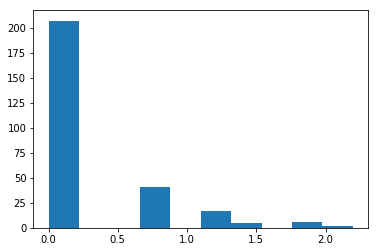

In [205]:
plt.hist(np.log(np.array(nofeat_vars)+1));
#plt.hist(np.log(np.array(feat_vars)+1));

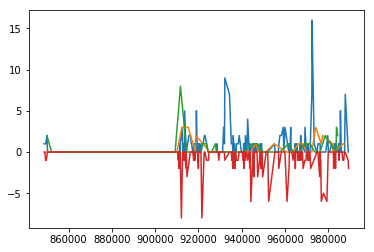

In [193]:
plt.plot(peak_gff[(peak_gff.type=='CDS')]['start'],
         peak_gff[(peak_gff.type=='CDS')]['nvars'],'-');
plt.plot(peak_gff[(peak_gff.type=='three_prime_UTR')]['start'],
         peak_gff[(peak_gff.type=='three_prime_UTR')]['nvars'],'-');
plt.plot(peak_gff[(peak_gff.type=='five_prime_UTR')]['start'],
         peak_gff[(peak_gff.type=='five_prime_UTR')]['nvars'],'-');
plt.plot(j,-np.array(nofeat_vars));

In [34]:
peak_vars.head()

,Pos,Ref,Alt,Start,End,aStart,aEnd,Subtype,status,invcf,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_Correction,SS-B873_Correction,SS-B360,SS-B397,SS-B564,SS-B382
3689,848749,G,A,848748,848749,848748,848749,ts,MODIFIER,CNB02850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3690,849026,T,A,849025,849026,849025,849026,tv,MODERATE,CNB02860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3691,849236,G,A,849235,849236,849235,849236,ts,MODERATE,CNB02860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3692,849436,C,G,849435,849436,849435,849436,tv,MODIFIER,CNB02850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3693,849555,T,C,849554,849555,849554,849555,ts,LOW,CNB02860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [83]:
peak_gene_pos = np.concatenate([np.arange(*a) for a in peak_gff[['start','end']].values])

In [84]:
notgene_pos = np.array([a for a in np.arange(*peak) if a not in peak_gene_pos])

In [85]:
len(peak_gene_pos)

114139

In [87]:
len(notgene_pos)

30113

In [42]:
posofvars_in_peak_genes = peak_vars[(peak_vars.Start.isin(peak_gene_pos)) | (peak_vars.End.isin(peak_gene_pos))].Start.values

In [90]:
posofvars_in_peak_genes.shape

(259,)

In [88]:
posofvars_oo_peak_genes = peak_vars[(peak_vars.Start.isin(notgene_pos)) | (peak_vars.End.isin(notgene_pos))].Start.values

In [89]:
posofvars_oo_peak_genes.shape

(86,)

In [46]:
np.max(posofvars_in_peak_genes)

986901

In [47]:
np.min(posofvars_in_peak_genes)

850028

In [54]:
windows = np.arange(850000,990000,1000)

In [63]:
a = np.array([1, 3, 5, 6, 9, 10, 14, 15, 56])

np.where(np.logical_and(a>=6, a<=10))

(array([3, 4, 5]),)

In [71]:
nvar_in_genes = [sum(np.where(
    np.logical_and( 
        posofvars_in_peak_genes > windows[i]
        ,posofvars_in_peak_genes < windows[i+1]))[0]) for i in range(len(windows)-1)]

In [91]:
nvar_oo_genes = [sum(np.where(
    np.logical_and( 
        posofvars_oo_peak_genes > windows[i]
        ,posofvars_oo_peak_genes < windows[i+1]))[0]) for i in range(len(windows)-1)]

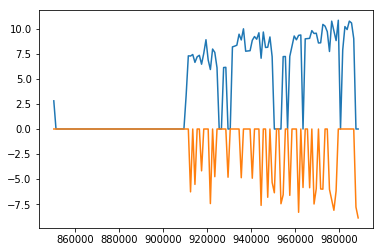

In [102]:
plt.plot(windows[:-1]+500,1*np.log2(np.array(nvar_in_genes)+1),'-');
plt.plot(windows[:-1]+500,-1*np.log2(np.array(nvar_oo_genes)+1),'-');

In [105]:
ch_gff[(ch_gff.type.isin(['CDS','three_prime_UTR','five_prime_UTR']))].head()

,type,strand,phase,attribute,gene,start,end,chrom
48958,CDS,+,0,ID=CNB00010-t26_1-p1-CDS1;Parent=CNB00010-t26_...,CNB00010,637,1652,Chr02
48959,CDS,+,2,ID=CNB00010-t26_1-p1-CDS2;Parent=CNB00010-t26_...,CNB00010,1710,2012,Chr02
32517,five_prime_UTR,+,.,ID=utr_CNB00020-t26_1_1;Parent=CNB00020-t26_1,CNB00020,3550,3667,Chr02
32514,CDS,+,0,ID=CNB00020-t26_1-p1-CDS1;Parent=CNB00020-t26_...,CNB00020,3667,3693,Chr02
32515,CDS,+,1,ID=CNB00020-t26_1-p1-CDS2;Parent=CNB00020-t26_...,CNB00020,3764,3968,Chr02


In [20]:
modifiedix = [i[0] for i in peak_gene_nonsyn.iterrows()
              if i[1]['Result'].split(':')[0] == 'Modified'][0]

In [21]:
agene_name = peak_gene_nonsyn['Name'][modifiedix]
agene_name

'CNB03090'

In [22]:
gene_gdf = gff_gene(agene_name,vardf,ch_gff,contigrec.seq)
print(gene_gdf.shape)

(4467, 8)


In [23]:
gene_ref_aa = gene_protien(gene_gdf,a='Ref')
gene_alt_aa = gene_protien(gene_gdf,a='Alt')
print(protien_compare(gene_ref_aa,gene_alt_aa))

Modified:1180


/Users/croth/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2576: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [24]:
gene_gdf[(gene_gdf.Seq==1) & (gene_gdf.Var==1)]

,Start,End,Ref,Alt,Var,Strand,Seq,Gene
744,931706,931707,A,G,1,-1,1,CNB03090
749,931711,931712,G,A,1,-1,1,CNB03090
867,931829,931830,G,A,1,-1,1,CNB03090
1026,931988,931989,C,T,1,-1,1,CNB03090
1498,932460,932461,G,A,1,-1,1,CNB03090
1942,932904,932905,T,C,1,-1,1,CNB03090
1990,932952,932953,T,C,1,-1,1,CNB03090
2038,933000,933001,A,G,1,-1,1,CNB03090
2352,933314,933315,A,G,1,-1,1,CNB03090
2360,933322,933325,TTC,TTA,1,-1,1,CNB03090


In [25]:
print(len(gene_ref_aa))
gene_ref_aa

1337


Seq('MGLIWSSLAHLAQPCYLPRASARDSHPHRPLSHPTAAPDMWGSNASTAASESTD...PPS', ExtendedIUPACProtein())

In [26]:
print(len(gene_alt_aa))
gene_alt_aa

157


Seq('MGLIWSSLAHLAQPCYLPRASARDSHPHRPLSHPTAAPDMWGSNASTAASESTD...LRL', ExtendedIUPACProtein())